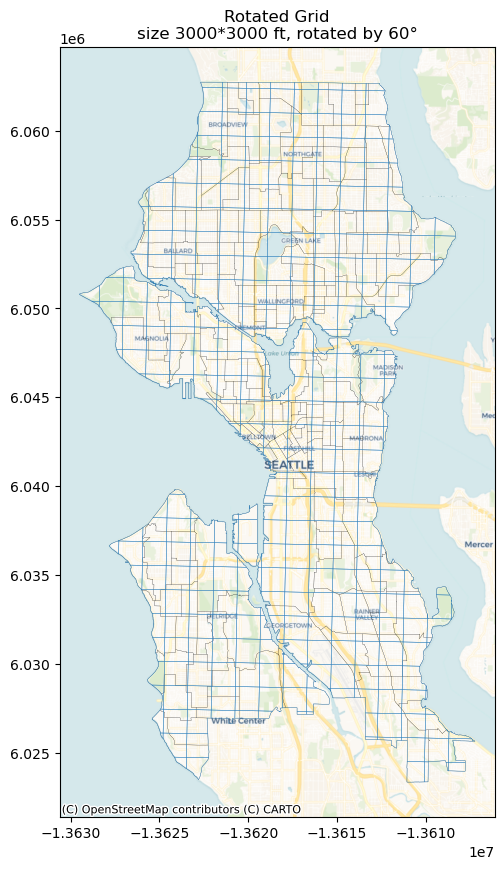

In [3]:
# 调整旋转角度
import geopandas as gpd
from shapely.geometry import box
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt
import contextily as cx


seattle_boundary = gpd.read_file("Seattle_City_Boundary.geojson")
seattle_boundary = seattle_boundary.to_crs(epsg=2272)  # Transform to a projection in feet


grid_size = 3000  


minx, miny, maxx, maxy = seattle_boundary.total_bounds# 整体下移
miny = miny -30000
x_range = maxx - minx
y_range = maxy - miny


rows = int(y_range / grid_size)
cols = int(x_range / grid_size) + 10

# 计算中心点
grid_center_x = minx + (x_range / 2)
grid_center_y = miny + (y_range / 2)

angle = 60
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
       
        cell = box(minx + i * grid_size, miny + j * grid_size, minx + (i + 1) * grid_size, miny + (j + 1) * grid_size)
        # cell 是需要进行平移操作的对象，它可能代表一个图形、单元格或其他需要进行变换的元素。
        
        # 先移动到(0,0),旋转， 再移动回原来位置。 这样保证了都是围绕原点旋转的
        cell = translate(cell, xoff=-grid_center_x, yoff=-grid_center_y)
        # xoff=-grid_center_x 和 yoff=-grid_center_y 是传入的参数，分别表示在 x 轴和 y 轴上的偏移量。
        # 这里使用 -grid_center_x 和 -grid_center_y 作为偏移量，目的是将 cell 的中心移动到原点 (0, 0)。
        # 因为 grid_center_x 和 grid_center_y 通常代表 cell 中心的坐标，通过减去这个坐标，就可以将其移动到原点位置1。
        cell = rotate(cell, angle=angle, origin=(0, 0))
        cell = translate(cell, xoff=grid_center_x, yoff=grid_center_y)
        # 这一行代码再次使用 translate 函数对 cell 进行平移操作。
        # xoff=grid_center_x 和 yoff=grid_center_y 表示在 x 轴和 y 轴上的偏移量。
        # 这里使用与第一步相反的偏移量，即 grid_center_x 和 grid_center_y，目的是将 cell 从原点移动回原来的位置。
        # 经过这一步操作，cell 完成了围绕原来中心位置的旋转1。
        
        grid.append(cell)

# 转化为geodataframe
grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=seattle_boundary.crs)

# 剪切
grid_gdf = gpd.clip(grid_gdf, seattle_boundary)

# 投影
projected_crs = '3857'
grid_gdf = grid_gdf.to_crs(epsg=projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg=projected_crs)


fig, ax = plt.subplots(figsize=(10, 10))

seattle_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.1)
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='#3182bd', linewidth=0.3)

# Add basemap
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title(f"Rotated Grid\nsize 3000*3000 ft, rotated by {angle}°")
plt.show()

为什么是-grid_center_x而不是grid_center_x

在代码 cell = translate(cell, xoff=-grid_center_x, yoff=-grid_center_y) 中使用 -grid_center_x 而非 grid_center_x，是为了将 cell 对象的中心移动到原点 (0, 0)。通常 grid_center_x 和 grid_center_y 代表 cell 对象中心的坐标。通过减去这个坐标，即使用 -grid_center_x 和 -grid_center_y 作为偏移量，就可以将 cell 对象移动到原点位置。这样做的目的是为后续围绕原点进行旋转操作做准备，因为在旋转操作中，围绕原点旋转的计算更为简单和直观。在完成旋转操作后，再通过 cell = translate(cell, xoff=grid_center_x, yoff=grid_center_y) 将 cell 对象从原点移动回原来的位置，从而实现 cell 对象围绕其原来中心位置的旋转操作